Install Dagster

In [1]:
!pip install -q dagster dagster-webserver

In [2]:
%matplotlib inline

Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from dagster import job, op, Out, In, repository, execute_job

## OPS (Pipeline Steps)

Load original dataset

In [4]:
@op(out=Out(pd.DataFrame))
def load_data():
    df = pd.read_csv("data/superstore.csv", encoding="latin1")
    return df

Load modified dataset (for selective rerun demo)

In [5]:
@op(out=Out(pd.DataFrame))
def load_data_modified():
    df = pd.read_csv("data/superstore_modified.csv", encoding="latin1")
    return df

Preprocessing

In [6]:
@op(ins={"df": In(pd.DataFrame)}, out=Out(pd.DataFrame))
def preprocess(df):
    df = df.copy()

    # Convert dates
    df["Order Date"] = pd.to_datetime(df["Order Date"])
    df["Ship Date"] = pd.to_datetime(df["Ship Date"])

    # Binary target (Profit > 0)
    df["target"] = (df["Profit"] > 0).astype(int)

    # Drop missing values
    df.dropna(inplace=True)

    return df

EDA

In [7]:
@op(ins={"df": In(pd.DataFrame)})
def eda(df):
    plt.figure(figsize=(6,4))
    sns.countplot(x="target", data=df)
    plt.title("Profit Distribution (0 = Loss, 1 = Profit)")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.scatterplot(x="Sales", y="Profit", data=df)
    plt.title("Sales vs Profit")
    plt.show()

Train/Test Split

In [8]:
@op(ins={"df": In(pd.DataFrame)}, out=Out(dict))
def split_data(df):
    X = df[["Sales", "Quantity", "Discount"]]
    y = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

Train Models

In [9]:
@op(ins={"split": In(dict)}, out=Out(dict))
def train_models(split):
    X_train, X_test, y_train, y_test = (
        split["X_train"], split["X_test"],
        split["y_train"], split["y_test"]
    )

    results = {}

    # Decision Tree
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_train, y_train)
    results["Decision Tree"] = (
        accuracy_score(y_train, dt.predict(X_train)),
        accuracy_score(y_test, dt.predict(X_test))
    )

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
    rf.fit(X_train, y_train)
    results["Random Forest"] = (
        accuracy_score(y_train, rf.predict(X_train)),
        accuracy_score(y_test, rf.predict(X_test))
    )

    # Logistic Regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(X_train, y_train)
    results["Logistic Regression"] = (
        accuracy_score(y_train, lr.predict(X_train)),
        accuracy_score(y_test, lr.predict(X_test))
    )

    return results

Plot Results

In [10]:
@op(ins={"results": In(dict)})
def plot_results(results):
    models = list(results.keys())
    train_acc = [results[m][0] for m in models]
    test_acc = [results[m][1] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, train_acc, width, label="Train Accuracy")
    plt.bar(x + width/2, test_acc, width, label="Test Accuracy")

    plt.ylabel("Accuracy")
    plt.title("Superstore Model Comparison")
    plt.xticks(x, models)
    plt.ylim(0,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

## JOBS (Pipelines)

Original data pipeline

In [11]:
@job
def superstore_pipeline_original():
    start = time.time()

    df = load_data()
    clean = preprocess(df)
    eda(clean)
    split = split_data(clean)
    results = train_models(split)
    plot_results(results)

    end = time.time()
    print(f"Dagster pipeline (original) time: {end - start:.2f} seconds")

Dagster pipeline (original) time: 0.00 seconds


Modified data pipeline

In [12]:
@job
def superstore_pipeline_modified():
    start = time.time()

    df = load_data_modified()
    clean = preprocess(df)
    eda(clean)
    split = split_data(clean)
    results = train_models(split)
    plot_results(results)

    end = time.time()
    print(f"Dagster pipeline (modified) time: {end - start:.2f} seconds")

Dagster pipeline (modified) time: 0.00 seconds


## REPOSITORY

In [13]:
@repository
def superstore_repo():
    return [
        superstore_pipeline_original,
        superstore_pipeline_modified
    ]

2026-01-31 13:36:47 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - RUN_START - Started execution of run for "superstore_pipeline_original".
2026-01-31 13:36:47 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - ENGINE_EVENT - Executing steps in process (pid: 5582)
2026-01-31 13:36:47 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 13:36:47 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 13:36:47 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - LOGS_CAPTURED - Started capturing logs in process (pid: 5582).
2026-01-31 13:36:47 +0000 - dagster - DEBUG -

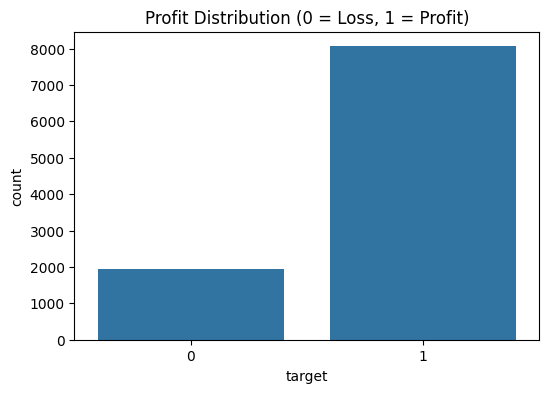

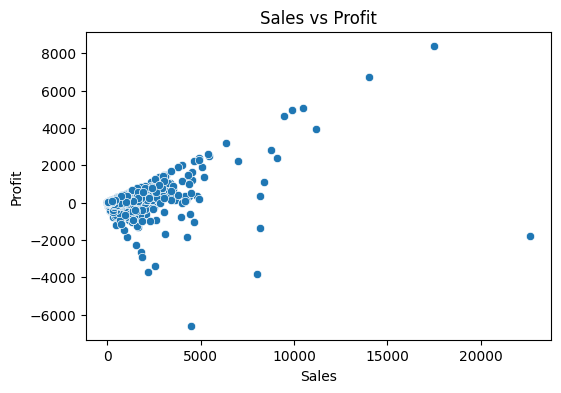

2026-01-31 13:36:48 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 13:36:48 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 13:36:48 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - eda - STEP_SUCCESS - Finished execution of step "eda" in 771ms.
2026-01-31 13:36:48 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - split_data - STEP_START - Started execution of step "split_data".
2026-01-31 13:36:48 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - split_data - LOADED_INPUT - Loaded input "df" using input manager "io_manager", from output "resul

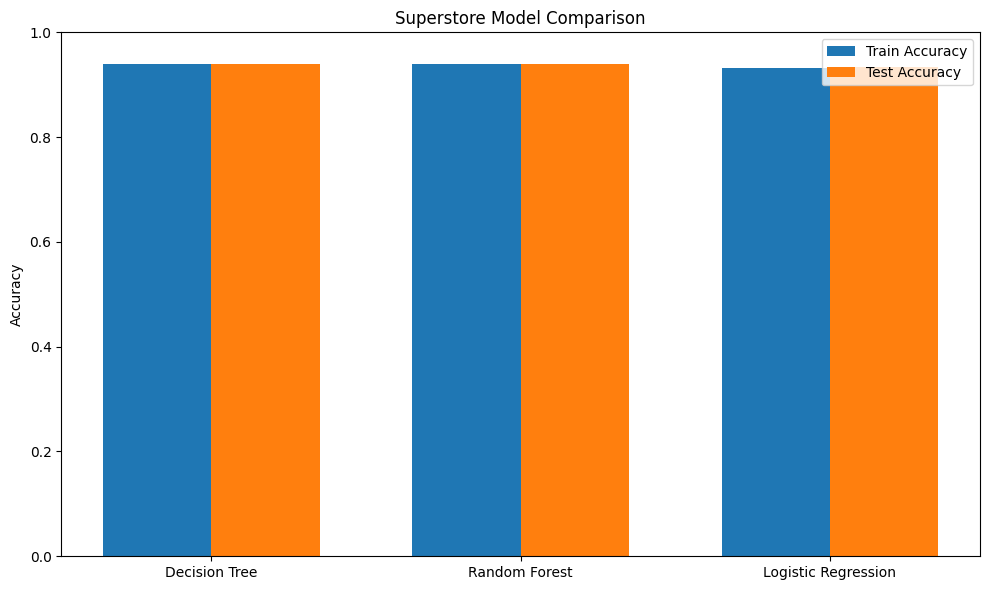

2026-01-31 13:36:50 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - plot_results - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 13:36:50 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - plot_results - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 13:36:50 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - plot_results - STEP_SUCCESS - Finished execution of step "plot_results" in 219ms.
/usr/local/lib/python3.12/dist-packages/dagster/_core/execution/context_creation_job.py:276: RuntimeWarning: coroutine 'BaseEventLoop.shutdown_asyncgens' was never awaited
  pass
2026-01-31 13:36:50 +0000 - dagster - DEBUG - superstore_pipeline_original - 1810d70c-3c1d-4403-a731-aff36561e4f6 - 5582 - ENGINE_EVENT - Finished steps in process (pid: 5582) in 2.39s
2026-01-31

Pipeline success: True


In [14]:
# ======================================
# EXECUTE DAGSTER JOB INSIDE THE NOTEBOOK
# ======================================

result = superstore_pipeline_original.execute_in_process()

print("Pipeline success:", result.success)

2026-01-31 13:36:51 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - RUN_START - Started execution of run for "superstore_pipeline_modified".
2026-01-31 13:36:51 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - ENGINE_EVENT - Executing steps in process (pid: 5582)
2026-01-31 13:36:51 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 13:36:51 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 13:36:51 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - LOGS_CAPTURED - Started capturing logs in process (pid: 5582).
2026-01-31 13:36:51 +0000 - dagster - DEBUG -

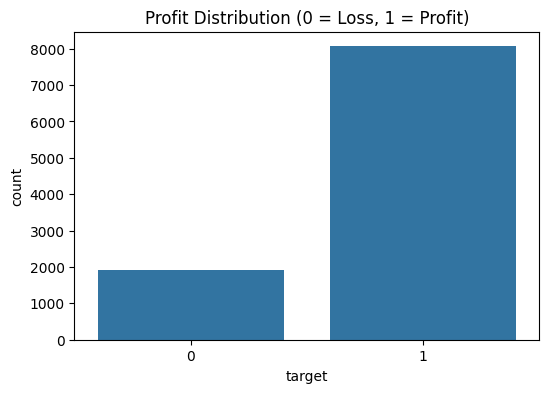

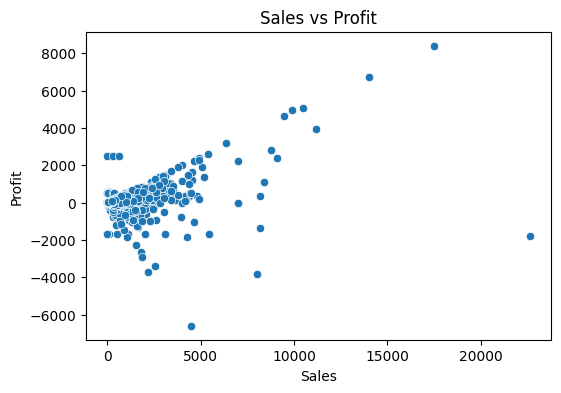

2026-01-31 13:36:52 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 13:36:52 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 13:36:52 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - eda - STEP_SUCCESS - Finished execution of step "eda" in 346ms.
2026-01-31 13:36:52 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - split_data - STEP_START - Started execution of step "split_data".
2026-01-31 13:36:52 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - split_data - LOADED_INPUT - Loaded input "df" using input manager "io_manager", from output "resul

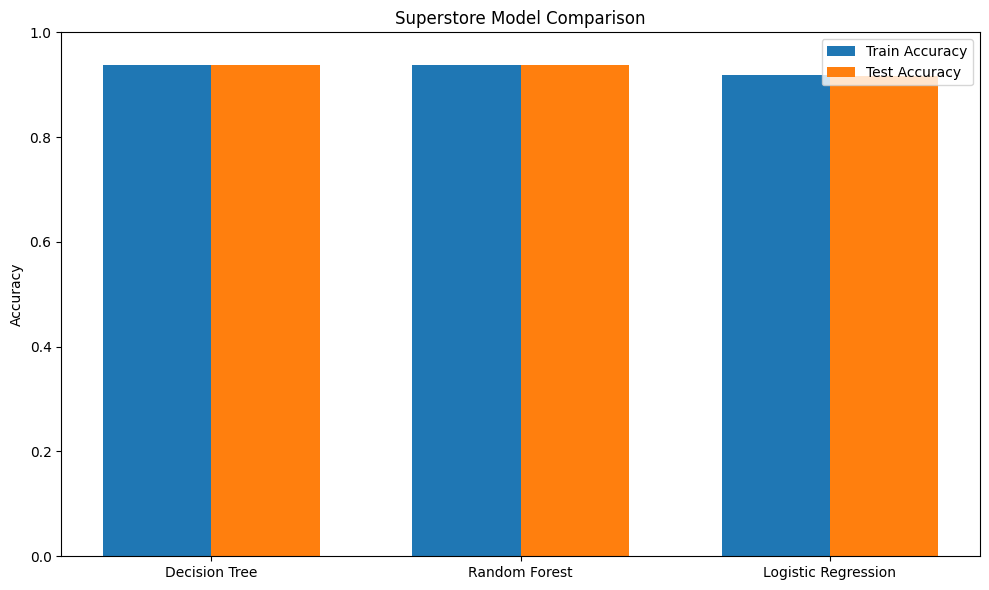

2026-01-31 13:36:53 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - plot_results - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 13:36:53 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - plot_results - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 13:36:53 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - plot_results - STEP_SUCCESS - Finished execution of step "plot_results" in 206ms.
/usr/local/lib/python3.12/dist-packages/dagster/_core/execution/context_creation_job.py:276: RuntimeWarning: coroutine 'BaseEventLoop.shutdown_asyncgens' was never awaited
  pass
2026-01-31 13:36:53 +0000 - dagster - DEBUG - superstore_pipeline_modified - f68848af-c7c5-4b31-9e58-3b85a3f8de34 - 5582 - ENGINE_EVENT - Finished steps in process (pid: 5582) in 1.44s
2026-01-31

Pipeline success: True


In [15]:
result = superstore_pipeline_modified.execute_in_process()
print("Pipeline success:", result.success)